In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import dense

### Mine Triplets

In [3]:
train_dict, train_files = data.get_data('train', keypoints=['Neck'])

preprocess False
keypoints ['Neck']
0.803660869598


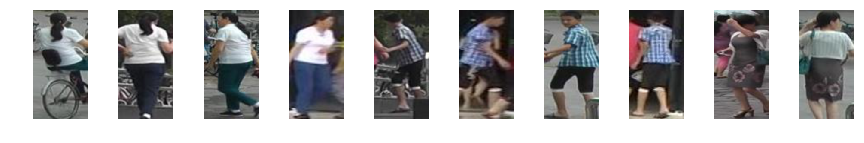

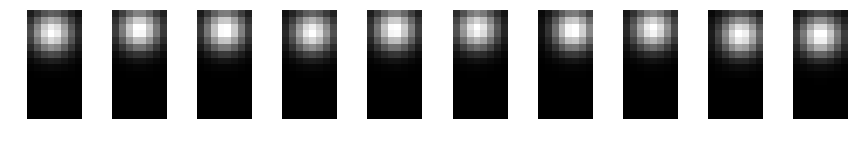

In [4]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=5, K=4, preprocess=False,
                                    shape=(256,128), keypoints=['Neck'], r=0.6).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(cv2.resize((255 * batch[0]['input_cam'][i]).astype(np.uint8), (8,16)), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

### Train Network

In [5]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

file_root = 'densenet_triplet_cam_neck_2'

In [6]:
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [7]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

# step_decay_cont_str = """
# def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0001):
#     drop = 0.5
#     epochs_drop = 10.0
#     lrate = init_lr * np.power(drop, (epoch + init_epoch)/(epochs_drop))
#     return lrate
# """

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0002):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

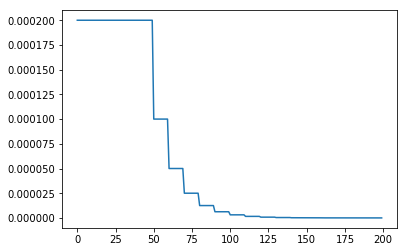

In [8]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [9]:
P_param = 5
K_param = 4

def_triplet_loss = """

import keras.backend as Keras

def triplet_loss(y_true, y_pred, margin=0.5, P=%d, K=%d, output_dim=%d):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))
    loss = Keras.variable(0, dtype='float32')

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(triplet.dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == 'soft':
                loss += triplet.log1p(hard_pos - hard_neg)
            else:
                loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss
""" % (P_param, K_param, 128)

exec(def_triplet_loss)

In [10]:
trinet = dense.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), cam_placement=[3], weights='imagenet')
trinet.compile(loss=triplet_loss, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

16 8
Weights for the model were loaded successfully


In [11]:
trinet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [12]:
# weights = np.load('/home/albert/github/tensorflow/models/densenet_triplet_cam_neck/densenet_triplet_cam_neck_4000.npy')
# trinet.set_weights(weights)

In [13]:
model_json = trinet.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [14]:
train_score = {}
history = History()

for era in range(1,11):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(data.output_batch_generator(train_dict, P=P_param, K=K_param, preprocess=True,
                                    shape=(256,128), keypoints=['Neck'], r=0.6), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.npy'
    np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), trinet.get_weights())
    
    train_score[iterations] = evaluation.get_score(trinet,
                                                   hist=history, preprocess=preprocess, 
                                                   shape=input_shape)
    print 'train' , iterations, train_score[iterations]['rank']

preprocess True
keypoints ['Neck']
Epoch 1/10
100/100 [==============================] - 78s - loss: 332.3917    
Epoch 2/10
100/100 [==============================] - 76s - loss: 220.0913    
Epoch 3/10
100/100 [==============================] - 75s - loss: 168.1831    
Epoch 4/10
100/100 [==============================] - 76s - loss: 165.2962    
Epoch 5/10
100/100 [==============================] - 75s - loss: 133.1869    
Epoch 6/10
100/100 [==============================] - 76s - loss: 106.9151    
Epoch 7/10
100/100 [==============================] - 76s - loss: 120.9780    
Epoch 8/10
100/100 [==============================] - 75s - loss: 99.1274    
Epoch 9/10
100/100 [==============================] - 75s - loss: 103.9400    
Epoch 10/10
100/100 [==============================] - 76s - loss: 74.9383    
1000 21.2948348522
2000 41.6272449493
3000 61.9416298866
4000 82.2834978104
5000 102.678719997
6000 122.975160837
7000 143.293297768
8000 163.594522953
9000 183.916782856
10000

KeyboardInterrupt: 

In [15]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)

### Evaluation

In [ ]:
evaluation.plot_rank(file_root, ylim_0=0.0)

In [ ]:
evaluation.plot_loss(file_root)

In [ ]:
file_root = 'densenet_triplet_front'

In [ ]:
evaluation.plot_rank(file_root)